In [160]:
%matplotlib notebook
import copy

from traitlets import Unicode, Bool, validate, TraitError
import ipywidgets as widgets

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from functools import partial

import cfl

In [8]:
create_slider = lambda label: widgets.FloatSlider(
    value=0,
    min=0,
    max=10,
    step=0.0001,
    description=label,
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.4f'
)

In [9]:
shepp_file = open("ksp_img.png", "rb")
shepp = shepp_file.read()
shepp_img = widgets.Image(
    value=shepp,
    format='png',
)

In [10]:
VBox = [create_slider(str(i)) for i in range(16)]

In [11]:
test = widgets.AppLayout(header=widgets.HBox([create_slider(num) for num in ["one", "two", "three", "four"]]),
                  left_sidebar=None, center=shepp_img, right_sidebar=widgets.VBox(VBox), footer=None)

In [12]:
test

AppLayout(children=(HBox(children=(FloatSlider(value=0.0, continuous_update=False, description='one', max=10.0…

In [190]:
class BartViewWidget(object):
    
    def __init__(self, cflname):
        
        # Read data
        self.cflname = cflname
        self.im = cfl.readcfl(self.cflname)
        self.im_unsqueeze_shape = np.where(np.array(self.im.shape) > 1)[0]
        self.im = self.im.squeeze()
        
        # Reorder image
        self.Ndims = len(self.im.shape)
        self.order = np.r_[:self.Ndims]
        self.im_ordered = self.im
        self.order3 = np.array([0, 1, 1])
        
        # Slice image
        self.slice_num = np.zeros(self.Ndims, dtype="int")
        self.im_shape = self.im_ordered.shape
        self.im_slice = self.im_ordered[(slice(None), slice(None)) + tuple(self.slice_num[2:])]
        
        # Create figure
        self.fig = plt.figure(facecolor='black', figsize=(4.5, 3))
        self.fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0)
        self.fig.canvas.set_window_title(self.cflname)
        
        # Show image
        self.immax = np.max(abs(self.im))
        self.l = plt.imshow(abs(self.im_slice), cmap="gray", vmin=0, vmax=self.immax)
        self.ax = plt.gca()
        self.asp = self.im_ordered.shape[1] / self.im_ordered.shape[0]
        self.aspect = 1
        self.ax.set_aspect(1)
        plt.axis('off')
        
        radios = []
        buttons = []
        sliders = []
        
        # Create Radio Buttons for X Y Dimensions
        dims = self.im_unsqueeze_shape[self.order].astype(str)
        for i in range(0, len(dims)):
            dims[i] = "Dim " + dims[i]
        up_down = widgets.RadioButtons(
            options=dims,
            description="Up/Down",
            disabled=False
        )
        radios.append(up_down)
        
        left_right = widgets.RadioButtons(
            options=dims,
            description="Left/Right",
            disabled=False
        )
        radios.append(left_right)
        
        # Create Radio buttoms for mosaic
        self.mosaic_valid = False
        mosaic = widgets.RadioButtons(
            options=dims,
            description="Mosaic",
            disabled=False
        )
        radios.append(mosaic)
        
        # create flip buttons
        self.flipx = 1
        flipx_button = widgets.Button(description="Flip Up/Down")
        buttons.append(flipx_button)
        
        self.flipy = 1
        flipy_button = widgets.Button(description="Flip Left/Right")
        buttons.append(flipy_button)
        
        # Create Refresh buttons
        refresh_button = widgets.Button(description="Refresh")
        buttons.append(refresh_button)
        
        # Create Save Button
        save_button = widgets.Button(description="Export to PNG")
        buttons.append(save_button)        
        
        # create magnitude/phase radio button
        self.magnitude = True
        magnitude_radios = widgets.RadioButtons(
            options=["Mag", "Phase"]
        )
        radios.append(magnitude_radios)
        
        # create aspect sliders
        aspect_slider = widgets.FloatSlider(min=0.25, max=4, step=0.05, value=1.0, description="Aspect Ratio")
        sliders.append(aspect_slider)
        
        # Create contrast sliders
        self.vmin = 0
        vmin_slider = widgets.FloatSlider(min=0, max=1, step=0.01, value=0, description="Contrast Min")
        sliders.append(vmin_slider)
        
        self.vmax = 1
        vmax_slider = widgets.FloatSlider(min=0, max=1, step=0.01, value=1, description="Contrast Max")
        sliders.append(vmax_slider)
        
        # Create sliders for choosing a slice
        dim_sliders = []
        for d in np.r_[:self.Ndims]:
            slice_slider = widgets.IntSlider(min=0, max=self.im_shape[d]-1, step=1, \
                                             value=self.slice_num[d], description=f'Dim {self.im_unsqueeze_shape[d]} Slice')
            sliders.append(slice_slider)
            dim_sliders.append(slice_slider)
        
        # Display widgets
        self.out = widgets.Output()
        
        controls = radios + buttons + sliders + [self.out]
        display(*controls)
        
        # Functionality
        up_down.observe(self.update_orderx, names='value')
        left_right.observe(self.update_ordery, names='value')
        mosaic.observe(self.update_mosaic, names='value')
        
        flipx_button.on_click(self.update_flipx)
        flipy_button.on_click(self.update_flipy)
        
        refresh_button.on_click(self.update_refresh)
        save_button.on_click(self.save)
        
        magnitude_radios.observe(self.update_magnitude, names='value')
        
        aspect_slider.observe(self.update_aspect, names='value')
        
        vmin_slider.observe(self.update_vmin, names='value')
        vmax_slider.observe(self.update_vmax, names='value')
        
        for dim_slider in dim_sliders:
            dim_slider.observe(self.update_slice, names='value')
        
        plt.show()
        
    def save(self, changes):
        #TODO Finish this - less essential for the demo
        return
        
    def on_value_change(self, change):
        with self.out:
            print(change)

    def update_orderx(self, change):
        l = int(change['new'][4:])
        self.order3[0] = np.where(self.im_unsqueeze_shape == l)[0]
        self.update_ordered_image()

    def update_ordery(self, change):
        l = int(change['new'][4:])
        self.order3[1] = np.where(self.im_unsqueeze_shape == l)[0]
        self.update_ordered_image()
        
    def update_flipx(self, changes):
        self.flipx *= -1
        self.update_image()

    def update_flipy(self, changes):
        self.flipy *= -1
        self.update_image()
        
    def update_refresh(self, event):
        self.update_image()
        
    def update_magnitude(self, changes):
        l = changes["new"]
        self.magnitude =  ( l == 'Mag' )
        if (self.magnitude):
            self.l.set_cmap('gray')
        else:
            #TODO: Update phase?
            self.l.set_cmap('hsv')
        self.update_image()
        
    def update_aspect(self, changes):
        aspect = changes['new']
        self.aspect = aspect
        self.ax.set_aspect(self.asp * self.im_ordered.shape[0] / self.im_ordered.shape[1] * aspect)
        
    def update_vmax(self, changes):
        vmax = changes['new']
        self.vmax = max(self.vmin, vmax)
        self.l.set_clim(vmax = self.vmax * self.immax)

    def update_vmin(self, changes):
        vmin = changes['new']
        self.vmin = min(self.vmax,vmin)
        self.l.set_clim(vmin = self.vmin * self.immax)
        
    def update_ordered_image(self):
        self.mosaic_valid = len( self.order3[:3] ) == len( set( self.order3[:3] ) )
        self.order_valid = len( self.order3[:2] ) == len( set( self.order3[:2] ) );
                            
        if (self.mosaic_valid):
            self.order[:3] = self.order3[:3]
            order_remain = np.r_[:self.Ndims]
            for t in np.r_[:3]:
                order_remain = order_remain[  (order_remain != self.order[t] ) ]
            self.order[3:] = order_remain
            self.im_ordered = np.transpose( self.im, self.order )
            self.ax.set_aspect( self.asp * self.im_ordered.shape[0] / self.im_ordered.shape[1] * self.aspect )
            self.update_image()
        elif (self.order_valid):
            self.order[:2] = self.order3[:2]
            order_remain = np.r_[:self.Ndims]
            for t in np.r_[:2]:
                order_remain = order_remain[  (order_remain != self.order[t] ) ]
            self.order[2:] = order_remain
            self.im_ordered = np.transpose( self.im, self.order )
            self.ax.set_aspect( self.asp * self.im_ordered.shape[0] / self.im_ordered.shape[1] * self.aspect )
            self.update_image()


    def update_image(self):
        self.immax = np.max(abs(self.im))
        self.l.set_clim(vmin = self.vmin * self.immax,  vmax = self.vmax * self.immax);
        if (self.mosaic_valid):
            im_slice = self.im_ordered[ (slice(None,None,self.flipx), slice(None,None,self.flipy), slice(None)) + tuple(self.slice_num[self.order[3:]])]
            im_slice = self.mosaic( im_slice )
        else:
            im_slice = self.im_ordered[(slice(None,None,self.flipx), slice(None,None,self.flipy)) + tuple(self.slice_num[self.order[2:]])]
        
        if self.magnitude:
            self.l.set_data( abs(im_slice) )
        else:
            self.l.set_data( (np.angle(im_slice) + np.pi) / (2 * np.pi) )
            
        self.fig.canvas.draw()
        
    def update_slice(self, changes):
        d = int(changes["owner"].description[4])
        s = changes["new"]
        print(self.slice_num)
        self.slice_num[d] = s
        self.update_image()
        
    def mosaic( self, im ):
        im = im.squeeze()
        (x, y, z) = im.shape
        z2 = int( np.ceil( z ** 0.5 ) )
        z = int( z2 ** 2 )
        im = np.pad( im, [(0,0), (0,0), (0, z - im.shape[2] )], mode='constant')
        im = im.reshape(  (x, y * z, 1), order = 'F' )

        im = im.transpose( (1, 2, 0) )
        im = im.reshape( (y * z2 , z2, x), order = 'F' )
        im = im.transpose( (2, 1, 0) )
        im = im.reshape( (x * z2, y * z2), order = 'F' )

        return im

    def update_mosaic( self, changes):
        l = int(changes['new'][4:])
        self.order3[2] = np.where( self.im_unsqueeze_shape == l )[0]
        self.update_ordered_image()

<IPython.core.display.Javascript object>


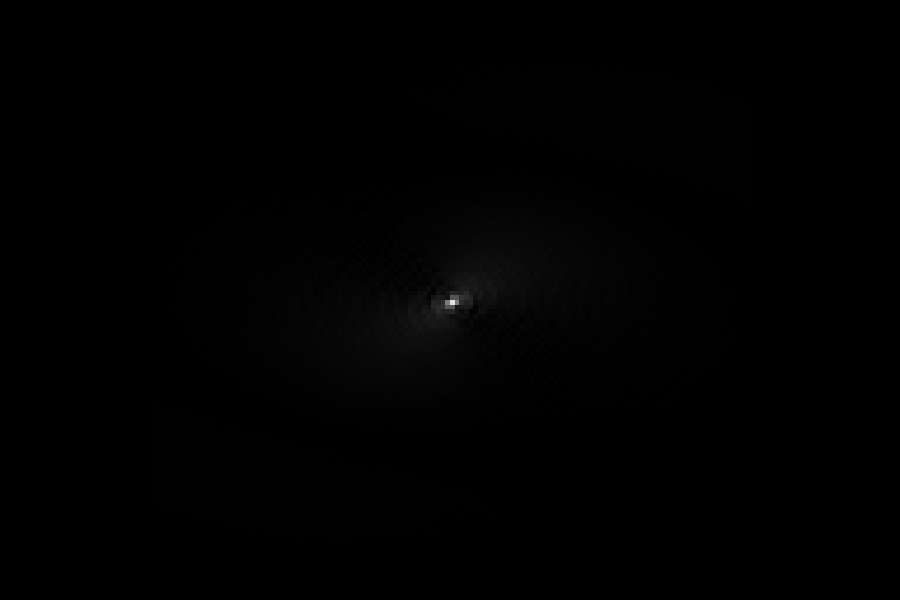

RadioButtons(description='Up/Down', options=('Dim 0', 'Dim 1', 'Dim 3'), value='Dim 0')

RadioButtons(description='Left/Right', options=('Dim 0', 'Dim 1', 'Dim 3'), value='Dim 0')

RadioButtons(description='Mosaic', options=('Dim 0', 'Dim 1', 'Dim 3'), value='Dim 0')

RadioButtons(options=('Mag', 'Phase'), value='Mag')

Button(description='Flip Up/Down', style=ButtonStyle())

Button(description='Flip Left/Right', style=ButtonStyle())

Button(description='Refresh', style=ButtonStyle())

Button(description='Export to PNG', style=ButtonStyle())

FloatSlider(value=1.0, description='Aspect Ratio', max=4.0, min=0.25, step=0.05)

FloatSlider(value=0.0, description='Contrast Min', max=1.0, step=0.01)

FloatSlider(value=1.0, description='Contrast Max', max=1.0, step=0.01)

IntSlider(value=0, description='Dim 0 Slice', max=127)

IntSlider(value=0, description='Dim 1 Slice', max=127)

IntSlider(value=0, description='Dim 3 Slice', max=3)

Output()

[0 0 0]


IndexError: index 3 is out of bounds for axis 0 with size 3

In [191]:
BartViewWidget('shepp')